# OFFSET_P Studies

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import pathlib
import datetime

In [15]:
import astropy.table

In [19]:
import pandas as pd

In [4]:
DESI = pathlib.Path('/global/cfs/cdirs/desi')
DATA = DESI / 'spectro' / 'data'
EON = DESI / 'engineering' / 'focalplane' / 'endofnight'

In [120]:
def get_all(night):
    
    summary = astropy.table.Table.read(EON / str(night) / f'fp-{night}.ecsv')
    df = summary.to_pandas()
    sel = (df.DEVICE_TYPE == 'POS') & (df.DEVICE_CLASSIFIED_NONFUNCTIONAL == False)
    return df[sel]

df_all = get_all(20241109)

In [99]:
def load(start, stop):
    
    # Load the summary for the stop date
    summary = astropy.table.Table.read(EON / str(stop) / f'fp-{stop}.ecsv')
    df = summary.to_pandas()
    sel = (df.DEVICE_TYPE == 'POS') & (df.DEVICE_CLASSIFIED_NONFUNCTIONAL == False) & (df.LINPHI == True)
    df = df[sel]
    df.set_index('LOCATION', inplace=True)
    locs = np.array(df.index)
    nlocs = len(locs)
    print(f'Analyzing {nlocs} devices')
    
    # Initialize the histograms for each device
    edges = np.linspace(-40, 200, 121)
    nbins = len(edges) - 1
    data = np.zeros((2,nlocs, nbins))
    
    # Loop over nights in [start,stop]
    fmt = "%Y%m%d"
    start = datetime.datetime.strptime(str(start), fmt)
    stop = datetime.datetime.strptime(str(stop), fmt)
    one = datetime.timedelta(days=1)
    day = start
    while day <= stop:
        night = day.strftime(fmt)
        print(night)
        movespath = EON / night / f'moves-{night}.csv.gz'
        if not movespath.exists():
            print(f'Skipping night with no moves: {night}')
            pass
        else:
            # Load moves data for this night
            moves = pd.read_csv(movespath, low_memory=False)
            # Select moves with a valid request and FVC-measured spot
            sel = ~(
                moves.req_p.isna() | moves.fvc_p.isna() |
                (moves.ctrl_enabled==0) | (moves.blocked == 1)
            )
            moves = moves[sel]
            # Loop over locations
            for k, loc in enumerate(locs):
                sel = moves.location == loc
                data[0,k] += np.histogram(moves[sel].req_p, bins=edges)[0]
                data[1,k] += np.histogram(moves[sel].fvc_p, bins=edges)[0]
        day += one
        
    return df, data, edges

df, data, edges = load(20240810, 20241109)

Analyzing 218 devices
20240810
20240811
20240812
20240813
20240814
20240815
20240816
Skipping night with no moves: 20240816
20240817
Skipping night with no moves: 20240817
20240818
20240819
20240820
20240821
20240822
20240823
Skipping night with no moves: 20240823
20240824
20240825
20240826
Skipping night with no moves: 20240826
20240827
20240828
20240829
20240830
20240831
20240901
20240902
20240903
Skipping night with no moves: 20240903
20240904
Skipping night with no moves: 20240904
20240905
20240906
20240907
20240908
20240909
20240910
20240911
20240912
20240913
20240914
20240915
Skipping night with no moves: 20240915
20240916
Skipping night with no moves: 20240916
20240917
Skipping night with no moves: 20240917
20240918
20240919
20240920
20240921
20240922
20240923
20240924
20240925
20240926
20240927
20240928
20240929
20240930
20241001
Skipping night with no moves: 20241001
20241002
20241003
20241004
20241005
20241006
20241007
20241008
20241009
Skipping night with no moves: 20241009


In [148]:
def plot(idx):
    
    dev = df.iloc[idx]
    posid = dev.DEVICE_ID
    P = 0.5*(edges[1:]+edges[:-1])
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.hist(P, bins=edges, weights=data[1,idx], histtype='stepfilled', fc='b', alpha=0.25, label='Actual')
    ax.hist(P, bins=edges, weights=data[0,idx], histtype='step', ec='b', label='Requested')
    ax.axvline(185, c='r', ls='--', label='Full Range')
    ax.axvline(185 - dev.PHYSICAL_RANGE_P, c='r', ls='--')
    ax.axvline(185 - 3, c='r', ls=':', label='Debounced Range')
    ax.axvline(185 - dev.PHYSICAL_RANGE_P + 6, c='r', ls=':')
    ax.axvline(150 - dev.OFFSET_P, c='c', ls='-', label='150,180-OFFSET_P')
    ax.axvline(180 - dev.OFFSET_P, c='c', ls='-')
    ax.legend()
    ax.set(yticks=[], xlabel=f'{posid} intP [deg]', yscale='log')
    plt.savefig(f'plots/{posid}.jpg')
    return fig, ax

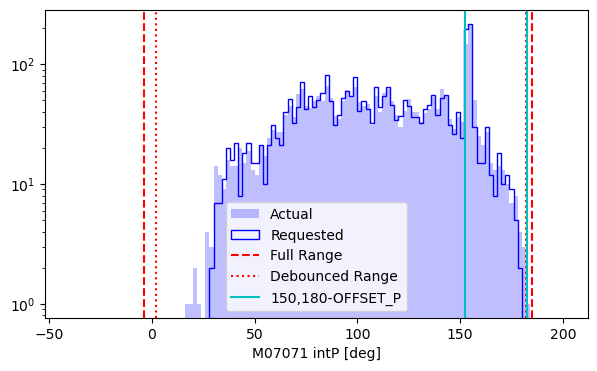

In [149]:
plot(3);

In [150]:
def plot_all():
    n = data.shape[1]
    for idx in range(n):
        fig, ax = plot(idx)
        plt.close(fig)
        
%time plot_all()

CPU times: user 53.4 s, sys: 28.1 s, total: 1min 21s
Wall time: 51.2 s


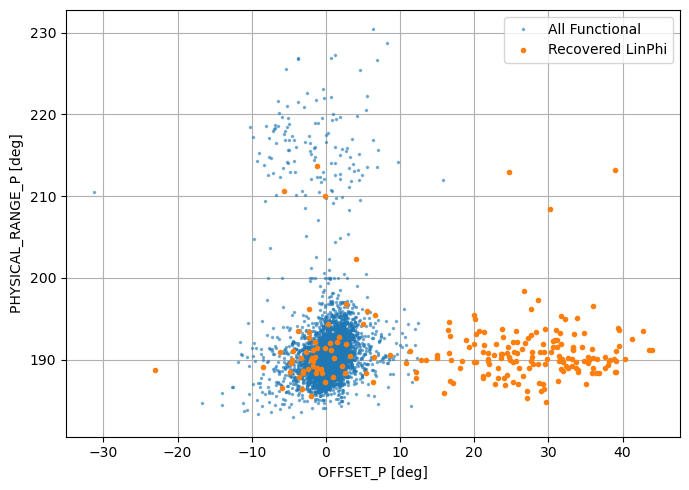

In [127]:
def plot_meta():
    
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(df_all.OFFSET_P, df_all.PHYSICAL_RANGE_P, '.', ms=3, alpha=0.5, label='All Functional')
    ax.plot(df.OFFSET_P, df.PHYSICAL_RANGE_P, '.', label='Recovered LinPhi')
    ax.legend()
    ax.grid()
    ax.set(xlabel='OFFSET_P [deg]', ylabel='PHYSICAL_RANGE_P [deg]')
    plt.tight_layout()
    plt.savefig('phi-calib.jpg')
    
plot_meta()

## Phi Allowed Range

From the [petal code](https://desi.lbl.gov/trac/browser/code/focalplane/plate_control/trunk/petal?order=name):

#### [posconstants.py](https://desi.lbl.gov/trac/browser/code/focalplane/plate_control/trunk/petal/posconstants.py)

```python
  "ANTIBACKLASH_FINAL_MOVE_DIR_P":  1,
  "BACKLASH": 3.0,
  "PRINCIPLE_HARDSTOP_CLEARANCE_P": 3.0,
  "PRINCIPLE_HARDSTOP_DIR_P": 1,
  "SECONDARY_HARDSTOP_CLEARANCE_P": 3.0,
```

#### [posmodel.py](https://desi.lbl.gov/trac/browser/code/focalplane/plate_control/trunk/petal/posmodel.py)

```python
def _calc_hardstop_clearance(self):
    """Minimum distance to stay clear from hardstop.
    Returns [1x2] array of [clearance_at_min_limit, clearance_at_max_limit].
    These are DIRECTIONAL quantities (i.e., the sign indicates the direction
    in which one would debounce after hitting the given hardstop, to get
    back into the accessible range).
    """
    if self.axisid == pc.T:
        if self.principle_hardstop_direction < 0:
            return [+self.posmodel.state._val['PRINCIPLE_HARDSTOP_CLEARANCE_T'],
                    -self.posmodel.state._val['SECONDARY_HARDSTOP_CLEARANCE_T']]
        else:
            return [+self.posmodel.state._val['SECONDARY_HARDSTOP_CLEARANCE_T'],
                    -self.posmodel.state._val['PRINCIPLE_HARDSTOP_CLEARANCE_T']]
    else:
        if self.principle_hardstop_direction < 0:
            return [+self.posmodel.state._val['PRINCIPLE_HARDSTOP_CLEARANCE_P'],
                    -self.posmodel.state._val['SECONDARY_HARDSTOP_CLEARANCE_P']]
        else:
            return [+self.posmodel.state._val['SECONDARY_HARDSTOP_CLEARANCE_P'],
                    -self.posmodel.state._val['PRINCIPLE_HARDSTOP_CLEARANCE_P']]    
```
Combined with the constants above, `hardstop_clearance = [+3,-3]`.

```python
def _calc_backlash_clearance(self):
    """Minimum clearance distance required for backlash removal moves.
    Returns 1x2 array of [clearance_from_low_side_of_range, clearance_from_high_side].
    These are DIRECTIONAL quantities (i.e., the sign indicates the direction
    similarly as the hardstop clearance directions).
    """
    if self.antibacklash_final_move_dir > 0:
        return [+self.posmodel.state._val['BACKLASH'],0]
    else:
        return [0,-self.posmodel.state._val['BACKLASH']]
```
Combined with the constants above, `backlash_clearance = [+3,0]`.

```python
def _calc_hardstop_debounce(self):
    """This is the amount to debounce off the hardstop after striking it.
    It is the hardstop clearance distance plus the backlash removal distance.
    Returns [1x2] array of [min,max]
    """
    h = self.hardstop_clearance
    b = self.backlash_clearance
    return [h[0] + b[0], h[1] + b[1]]
```
Combining with the above results, `hardstop_debounce = [+6, -3]`.

```python
def _calc_full_range(self):
    """Calculated from physical range only, with no subtraction of debounce
    distance.
    Returns [1x2] array of [min,max]
    """
    if self.axisid == pc.T:
        r = abs(self.posmodel.state._val['PHYSICAL_RANGE_T'])
        return [-0.50*r, 0.50*r]  # split theta range such that 0 is essentially in the middle
    else:
        r = abs(self.posmodel.state._val['PHYSICAL_RANGE_P'])
        return [185.0-r, 185.0]  # split phi range such that 0 is essentially at the minimum
```
Therefore `full_range = [185 - PHYSICAL_RANGE_P, 185]`.

```python
def _calc_debounced_range(self):
    """Calculated from full range, accounting for removal of both the hardstop
    clearance distances and the backlash removal distance.
    Returns [1x2] array of [min,max]
    """
    f = self.full_range
    h = self.hardstop_debounce # includes "backlash" and "clearance"
    return [f[0] + h[0], f[1] + h[1]]
```
Therefore `debounced_range = [185 - PHYSICAL_RANGE_P + 6, 185 - 3]`.